In [2]:
# https://medium.com/@srijaneogi31/predict-your-wine-quality-using-deep-learning-with-pytorch-424d736f0880
import torch
import torchvision
import matplotlib
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split


In [3]:
dataframe_raw = pd.read_csv("./winequality-white.csv",delimiter=";")
dataframe_raw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
input_cols= list(dataframe_raw.columns)[:-1]
output_cols = ['quality']
input_cols, output_cols

(['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol'],
 ['quality'])

In [8]:
def dataframe_to_arrays(dataframe):
    dataframe1 = dataframe.copy(deep=True)
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array
inputs_array, targets_array = dataframe_to_arrays(dataframe_raw)
inputs_array, targets_array

(array([[ 7.  ,  0.27,  0.36, ...,  3.  ,  0.45,  8.8 ],
        [ 6.3 ,  0.3 ,  0.34, ...,  3.3 ,  0.49,  9.5 ],
        [ 8.1 ,  0.28,  0.4 , ...,  3.26,  0.44, 10.1 ],
        ...,
        [ 6.5 ,  0.24,  0.19, ...,  2.99,  0.46,  9.4 ],
        [ 5.5 ,  0.29,  0.3 , ...,  3.34,  0.38, 12.8 ],
        [ 6.  ,  0.21,  0.38, ...,  3.26,  0.32, 11.8 ]]),
 array([[6],
        [6],
        [6],
        ...,
        [6],
        [7],
        [6]], dtype=int64))

In [10]:
inputs = torch.from_numpy(inputs_array).type(torch.float)
targets = torch.from_numpy(targets_array).type(torch.float)
print(inputs.shape,inputs)
print(targets.shape, targets)

torch.Size([4898, 11]) tensor([[ 7.0000,  0.2700,  0.3600,  ...,  3.0000,  0.4500,  8.8000],
        [ 6.3000,  0.3000,  0.3400,  ...,  3.3000,  0.4900,  9.5000],
        [ 8.1000,  0.2800,  0.4000,  ...,  3.2600,  0.4400, 10.1000],
        ...,
        [ 6.5000,  0.2400,  0.1900,  ...,  2.9900,  0.4600,  9.4000],
        [ 5.5000,  0.2900,  0.3000,  ...,  3.3400,  0.3800, 12.8000],
        [ 6.0000,  0.2100,  0.3800,  ...,  3.2600,  0.3200, 11.8000]])
torch.Size([4898, 1]) tensor([[6.],
        [6.],
        [6.],
        ...,
        [6.],
        [7.],
        [6.]])


In [11]:
dataset = TensorDataset(inputs, targets)
dataset

In [12]:
num_samples = inputs.shape[0]
train_ds, val_ds = random_split(dataset,[int(num_samples*0.8),num_samples - int(num_samples*0.8)] )
train_loader = DataLoader(train_ds, batch_size=50, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=50)

In [13]:
input_size = len(input_cols)
output_size = len(output_cols)
input_size, output_size

(11, 1)

In [17]:
class WineQuality(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, xb):
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.l1_loss(out, targets)
        return loss

    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = F.l1_loss(out, targets)
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result, num_epochs):
        if(epoch+1)%100==0 or epoch == num_epochs-1:
            print(f"Epoch[{epoch+1}], val_loss:{result['val_loss']:.4f}")

In [15]:
def evaluate(model:WineQuality, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit (epochs, lr,model:WineQuality, train_loader, val_loader, opt_func = torch.optim.SGD):
    history =[]
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [18]:
model = WineQuality()
epochs = 1500
lr = 1e-6
history5 = fit(epochs, lr, model,train_loader, val_loader)

Epoch[100], val_loss:1.9663
Epoch[200], val_loss:1.5128
Epoch[300], val_loss:1.2053
Epoch[400], val_loss:1.0372
Epoch[500], val_loss:0.9515
Epoch[600], val_loss:0.8897
Epoch[700], val_loss:0.8360
Epoch[800], val_loss:0.7891
Epoch[900], val_loss:0.7486
Epoch[1000], val_loss:0.7179
Epoch[1100], val_loss:0.6946
Epoch[1200], val_loss:0.6785
Epoch[1300], val_loss:0.6687
Epoch[1400], val_loss:0.6626
Epoch[1500], val_loss:0.6563


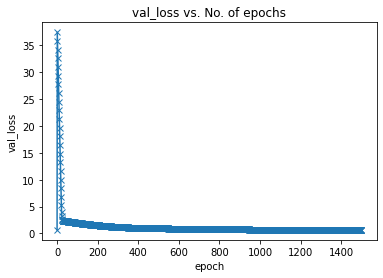

In [20]:
plt.title('val_loss vs. No. of epochs')
result = evaluate(model, val_loader)
loss_mat = [res['val_loss'] for res in [result]+history5]
plt.plot(loss_mat, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
val_loss = loss_mat[-1]

In [21]:
def  predict_single(input, target, model:WineQuality, printEnabled=True):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    if(printEnabled):
        print("Input: ", input)
        print("Target: ",target)
        print("Predictoin: " ,prediction)
    

<function matplotlib.pyplot.show(close=None, block=None)>

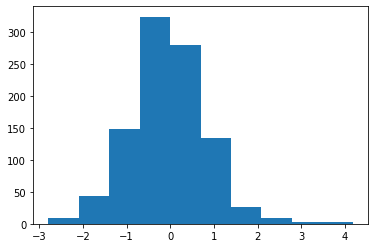

In [45]:
predictions=[]
targets=[]
for inputs, target in val_ds:
    inputs = inputs.unsqueeze(0)
    temp = model(inputs)
    predictions.append(temp.item())
    targets.append(target.item())

predictions, targets
plt.hist([p-t for p, t in zip(predictions, targets)],)
plt.show
# plt.plot(targets,predictions,'o')


In [40]:
input, target = val_ds[1]
predict_single(input, target, model)

Input:  tensor([5.1000e+00, 1.4000e-01, 2.5000e-01, 7.0000e-01, 3.9000e-02, 1.5000e+01,
        8.9000e+01, 9.9190e-01, 3.2200e+00, 4.3000e-01, 9.2000e+00])
Target:  tensor([6.])
Predictoin:  tensor([4.7859])
